# Mutual Information Minimization Demo

In this notebook, we provide a demo for how to use estimators in `mi_estimators.py` to minimize mutual information with sample pairs under multivariate Gaussian setups.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from mi_estimators import *

First, we define a Gaussian sampler to generate Gaussian samples which are differentiable to the covariance coefficients. More specifically, if $\left[\begin{array}{c} x \\ y \end{array}\right] \sim \mathcal{N}\left(\left[\begin{array}{c} 0\\0\end{array}\right], \left[\begin{array}{cc} 1 &\rho \\ \rho & 1\end{array} \right] \right) $, we can parameterize the covariance matrix by $\left[\begin{array}{cc} 1 &\rho \\ \rho & 1\end{array} \right] = {SS}^T$ with $S =\left[\begin{array}{cc} \cos \theta &\sin \theta \\ \sin \theta & \cos \theta \end{array} \right]$. Then $\left[\begin{array}{c} x \\ y \end{array}\right] = Sz$ with $z$ as a standard Gaussian random vector. We aim to optimize parameter $\theta$ to minimize the mutual information between $x$ and $y$.

In [2]:
class GaussianSampler(nn.Module):
    def __init__(self, dim, para_list = None):
        super(GaussianSampler, self).__init__()
        self.dim = dim
        if para_list is None:
            para_list = [0.55] * dim
        self.p_theta_ = torch.nn.Parameter(torch.tensor(para_list, requires_grad = True))
        
    def get_trans_mat(self):
        p_theta = self.p_theta_.cuda().unsqueeze(-1)
        #p_theta = torch.softmax(p_theta, dim = 0)

        trans_row1 = torch.cat((torch.sin(p_theta),torch.cos(p_theta)), dim=-1).unsqueeze(-1)
        trans_row2 = torch.cat((torch.cos(p_theta),torch.sin(p_theta)), dim=-1).unsqueeze(-1)  #[dim, 2,1]
        return torch.cat((trans_row1, trans_row2), dim=-1)  #[dim,2,2]

    def gen_samples(self, num_sample, cuda = True):
        noise= torch.randn(self.dim,num_sample,2).cuda()
        trans_mat = self.get_trans_mat()
        samples = torch.bmm(noise, trans_mat).transpose(0,1) #[dim, nsample, 2]
        if not cuda:
            samples = samples.cpu().detach().numpy()
        return samples[:,:,0], samples[:,:,1] 

    def get_covariance(self):
        p_theta = self.p_theta_.cuda()
        return (2.*torch.sin(p_theta)*torch.cos(p_theta))

    def get_MI(self):
        rho = self.get_covariance()
        return -1./2.*torch.log(1-rho**2).sum().item()
        #return -self.dim /2.*torch.log(1-rho**2 / 2).sum().item()



In [3]:
lr = 1e-4
batch_size = 100
num_iter = 5000
sample_dim = 2
hidden_size = 5
estimator_name = "CLUB" 

We can plot the sample pairs of variable $x$ and $y$, which has a high linear correlation.

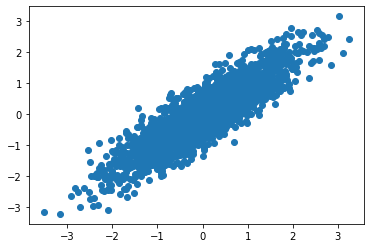

In [4]:
sampler = GaussianSampler(sample_dim).cuda()
#print("The corvariance of Gaussian is {}".format(sampler.get_covariance().cpu().detach().numpy()))
x_sample, y_sample = sampler.gen_samples(1000, cuda = False)
plt.scatter(x_sample, y_sample)
plt.show()

Then we optimize parameter $\theta$ to minimize the mutual information with only samples from the Gaussian distribution.

In [5]:
mi_estimator = eval(estimator_name)(sample_dim, sample_dim, hidden_size).cuda()

sampler_optimizer = torch.optim.Adam(sampler.parameters(), lr = lr)
mi_optimizer = torch.optim.Adam(mi_estimator.parameters(), lr = lr)

mi_true_values = []
mi_est_values = []
min_mi = 100.

for i in range(num_iter):
    sampler.train()
    mi_estimator.eval()
    x_samples, y_samples = sampler.gen_samples(batch_size)
    sampler_loss = mi_estimator(x_samples, y_samples)
    sampler_optimizer.zero_grad()
    sampler_loss.backward() # retain_graph=True)
    sampler_optimizer.step()

    for j in range(5):
        mi_estimator.train()
        x_samples, y_samples = sampler.gen_samples(batch_size)
        mi_loss = mi_estimator.learning_loss(x_samples, y_samples)
        mi_optimizer.zero_grad()
        mi_loss.backward()
        mi_optimizer.step()

    mi_true_values.append(sampler.get_MI())
    mi_est_values.append(mi_estimator(x_samples, y_samples).item())
    if i % 100 ==0:
        print("step {}, true MI value {}".format(i, sampler.get_MI()))

step 0, true MI value 1.5803104639053345
step 100, true MI value 1.5069398880004883
step 200, true MI value 1.411742091178894
step 300, true MI value 1.3095365762710571
step 400, true MI value 1.207322120666504
step 500, true MI value 1.1067947149276733
step 600, true MI value 1.0125977993011475
step 700, true MI value 0.9223268628120422
step 800, true MI value 0.8374634981155396
step 900, true MI value 0.7600098848342896
step 1000, true MI value 0.6891635656356812
step 1100, true MI value 0.6231958270072937
step 1200, true MI value 0.5628352165222168
step 1300, true MI value 0.5081000924110413
step 1400, true MI value 0.45843255519866943
step 1500, true MI value 0.41394031047821045
step 1600, true MI value 0.37355464696884155
step 1700, true MI value 0.338809996843338
step 1800, true MI value 0.30735206604003906
step 1900, true MI value 0.27980297803878784
step 2000, true MI value 0.25478222966194153
step 2100, true MI value 0.2324725091457367
step 2200, true MI value 0.21172374486923

We can plot the true MI values and the estimated MI values in each batch. The true MI value continuously decreases during the training. The estimated MI value first increases then decreases. The beginning increasing of estimated MI is because the estimator has not learned well from the samples. Then the decreasing process is the result of minimizing MI as learning loss.

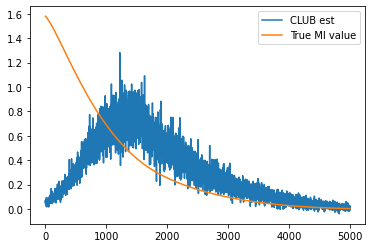

In [6]:
plt.plot(np.arange(len(mi_est_values)), mi_est_values, label=estimator_name + " est")
plt.plot(np.arange(len(mi_true_values)), mi_true_values, label="True MI value")
plt.legend()
plt.show()


We can plot samples of the optimized Gaussian sampler again, where the linear correlation between $x$ and $y$ has disappeared.

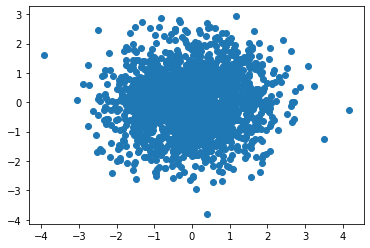

In [7]:
x_sample, y_sample = sampler.gen_samples(1000, cuda=False)
plt.scatter(x_sample, y_sample)
plt.show()